### Import Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

# For modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectFromModel, RFE, RFECV

# Set up visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

print("Libraries imported successfully!")

Libraries imported successfully!


### Load and Examine Data

In [35]:
# Load data
df = pd.read_csv('/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Synthetic Data/care_delay_data.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes)

# Preview data
print("\nFirst 5 rows:")
df.head()

Dataset shape: (786975, 21)

Data types:
mrn                         int64
age                         int64
gender                     object
comorbidities              object
num_comorbidities           int64
severity_score              int64
primary_diagnosis          object
care_date                  object
scheduled_care_time        object
actual_care_time           object
care_end_time              object
care_duration_minutes       int64
total_beds                  int64
occupied_beds               int64
staff_count                 int64
staff_to_patient_ratio    float64
care_delay_minutes          int64
day_of_week                 int64
hour_of_day                 int64
shift                      object
occupancy_rate            float64
dtype: object

First 5 rows:


,mrn,age,gender,comorbidities,num_comorbidities,severity_score,primary_diagnosis,care_date,scheduled_care_time,actual_care_time,...,care_duration_minutes,total_beds,occupied_beds,staff_count,staff_to_patient_ratio,care_delay_minutes,day_of_week,hour_of_day,shift,occupancy_rate
0,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-01-31,22:00:00,22:09:00,...,15,37,27,10,2.7,9,5,22,Evening,73.0
1,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,06:00:00,06:15:00,...,15,37,27,10,2.7,15,6,6,Night,73.0
2,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,08:13:00,08:38:00,...,15,37,27,10,2.7,25,6,8,Morning,73.0
3,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,10:00:00,10:16:00,...,15,37,27,10,2.7,16,6,10,Morning,73.0
4,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,14:00:00,14:14:00,...,15,37,27,10,2.7,14,6,14,Morning,73.0


### Initial Data Exploration

In [36]:
# Summary statistics
print("Summary statistics:")
df.describe().T

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
mrn,786975.0,4952.915730,2891.772068,1.0,2422.0,4947.0,7450.0,10000.0
age,786975.0,56.197417,17.981417,18.0,44.0,56.0,69.0,99.0
num_comorbidities,786975.0,1.649728,1.134816,0.0,1.0,2.0,2.0,4.0
severity_score,786975.0,2.993958,1.418198,1.0,2.0,3.0,4.0,5.0
care_duration_minutes,786975.0,30.308158,11.477434,9.0,21.0,29.0,39.0,64.0
total_beds,786975.0,33.981796,5.953839,22.0,29.0,34.0,38.0,48.0
occupied_beds,786975.0,29.105992,6.567473,16.0,24.0,28.0,34.0,47.0
staff_count,786975.0,6.712023,3.229501,2.0,4.0,6.0,8.0,23.0
staff_to_patient_ratio,786975.0,5.009308,1.729013,2.0,3.5,5.0,6.5,8.0
care_delay_minutes,786975.0,23.516222,11.249415,0.0,15.0,24.0,32.0,66.0


### Check Missing Values

In [37]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percent': missing_percent
})

print("Missing values analysis:")
missing_info[missing_info['Missing Values'] > 0]

Missing values analysis:


,Missing Values,Missing Percent
comorbidities,157915,20.066076


### Data Type Conversion

In [38]:
# Convert date and time columns to datetime
df['care_date'] = pd.to_datetime(df['care_date'])
df['scheduled_time'] = pd.to_datetime(df['scheduled_care_time'], format="%H:%M:%S").dt.time
df['actual_time'] = pd.to_datetime(df['actual_care_time'], format="%H:%M:%S").dt.time
df['end_time'] = pd.to_datetime(df['care_end_time'], format="%H:%M:%S").dt.time

# Convert time to hours (floating point)
df['scheduled_hour'] = df['scheduled_care_time'].apply(lambda x: float(x.split(':')[0]) + float(x.split(':')[1])/60)
df['actual_hour'] = df['actual_care_time'].apply(lambda x: float(x.split(':')[0]) + float(x.split(':')[1])/60)

# Extract month, day, year
df['month'] = df['care_date'].dt.month
df['day'] = df['care_date'].dt.day
df['year'] = df['care_date'].dt.year

print("Data types after conversion:")
print(df.dtypes)
df.head()

Data types after conversion:
mrn                                int64
age                                int64
gender                            object
comorbidities                     object
num_comorbidities                  int64
severity_score                     int64
primary_diagnosis                 object
care_date                 datetime64[ns]
scheduled_care_time               object
actual_care_time                  object
care_end_time                     object
care_duration_minutes              int64
total_beds                         int64
occupied_beds                      int64
staff_count                        int64
staff_to_patient_ratio           float64
care_delay_minutes                 int64
day_of_week                        int64
hour_of_day                        int64
shift                             object
occupancy_rate                   float64
scheduled_time                    object
actual_time                       object
end_time                    

,mrn,age,gender,comorbidities,num_comorbidities,severity_score,primary_diagnosis,care_date,scheduled_care_time,actual_care_time,...,shift,occupancy_rate,scheduled_time,actual_time,end_time,scheduled_hour,actual_hour,month,day,year
0,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-01-31,22:00:00,22:09:00,...,Evening,73.0,22:00:00,22:09:00,22:24:00,22.000000,22.150000,1,31,2025
1,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,06:00:00,06:15:00,...,Night,73.0,06:00:00,06:15:00,06:30:00,6.000000,6.250000,2,1,2025
2,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,08:13:00,08:38:00,...,Morning,73.0,08:13:00,08:38:00,08:53:00,8.216667,8.633333,2,1,2025
3,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,10:00:00,10:16:00,...,Morning,73.0,10:00:00,10:16:00,10:31:00,10.000000,10.266667,2,1,2025
4,1,63,F,"Tuberculosis,Hypertension",2,2,Malaria,2025-02-01,14:00:00,14:14:00,...,Morning,73.0,14:00:00,14:14:00,14:29:00,14.000000,14.233333,2,1,2025


### Exploratory Data Analysis - Target Variable

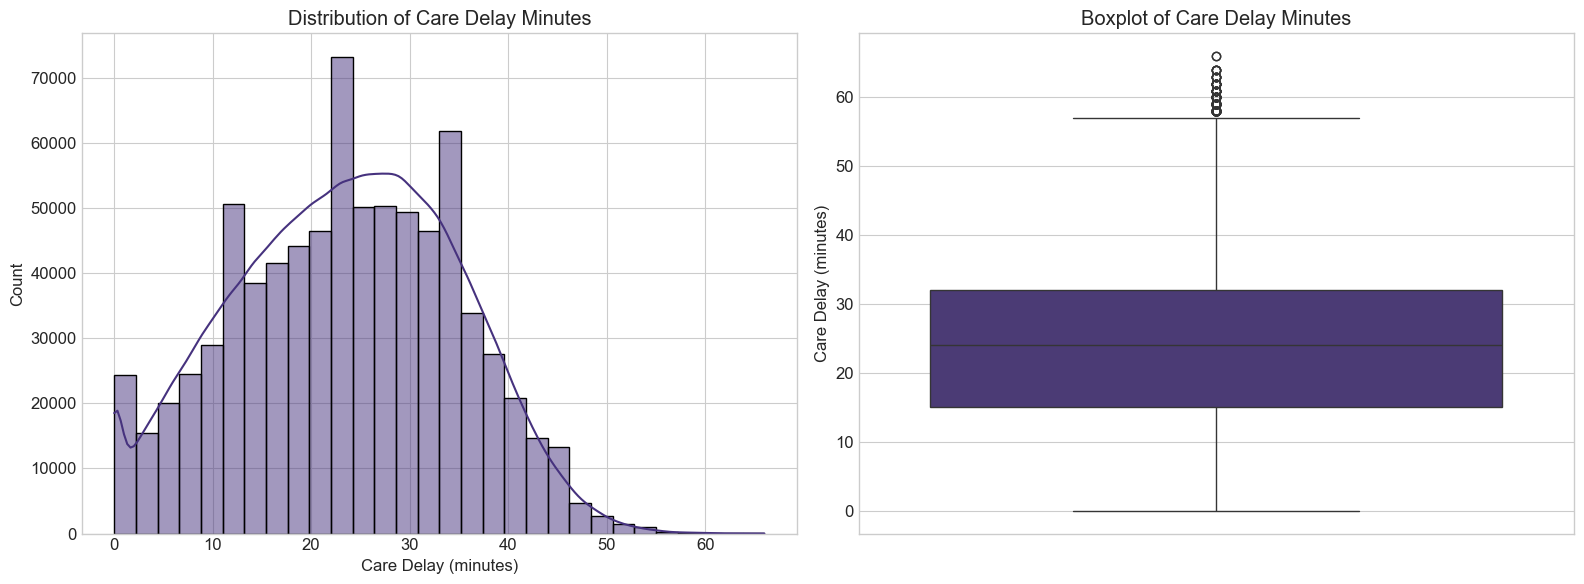

Care Delay Statistics:
Mean: 23.52 minutes
Median: 24.00 minutes
Min: 0.00 minutes
Max: 66.00 minutes
Standard Deviation: 11.25 minutes


In [39]:
# Analyze the target variable - care_delay_minutes
plt.figure(figsize=(16, 6))

plt.subplot(121)
sns.histplot(df['care_delay_minutes'], kde=True, bins=30)
plt.title('Distribution of Care Delay Minutes')
plt.xlabel('Care Delay (minutes)')

plt.subplot(122)
sns.boxplot(y=df['care_delay_minutes'])
plt.title('Boxplot of Care Delay Minutes')
plt.ylabel('Care Delay (minutes)')

plt.tight_layout()
plt.show()

print(f"Care Delay Statistics:")
print(f"Mean: {df['care_delay_minutes'].mean():.2f} minutes")
print(f"Median: {df['care_delay_minutes'].median():.2f} minutes")
print(f"Min: {df['care_delay_minutes'].min():.2f} minutes")
print(f"Max: {df['care_delay_minutes'].max():.2f} minutes")
print(f"Standard Deviation: {df['care_delay_minutes'].std():.2f} minutes")

### Exploratory Data Analysis - Care Delay vs Staff Ratio

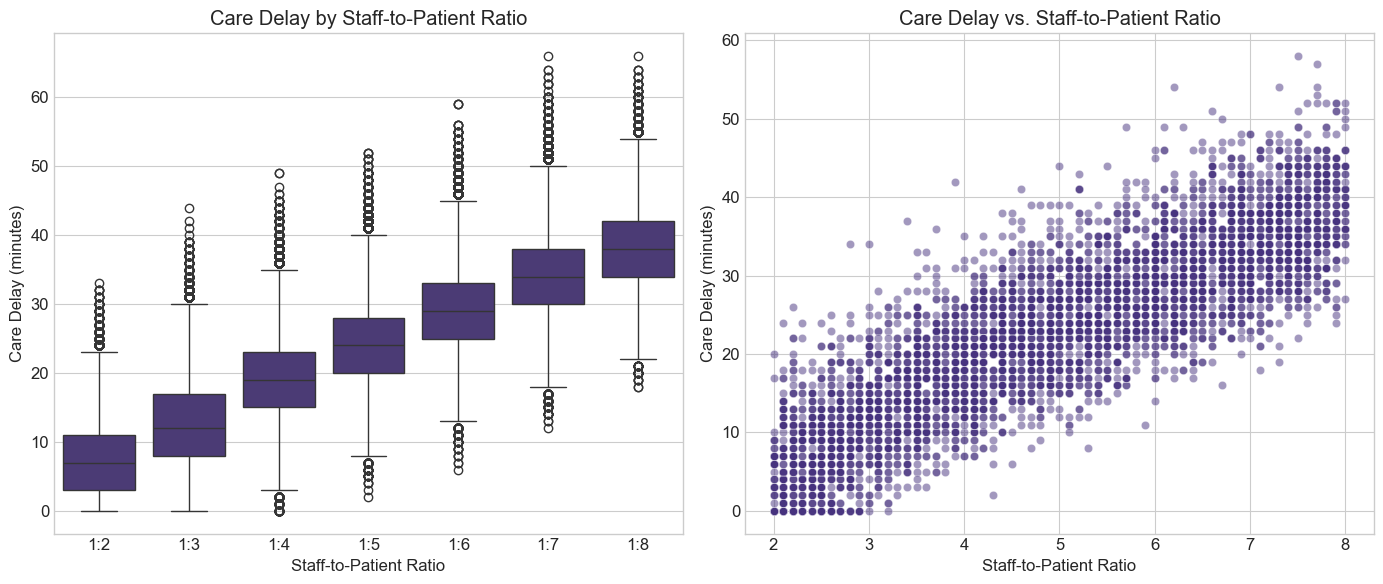

Correlation between staff-to-patient ratio and care delay: 0.8458


In [40]:
# Analyze the relationship with staff-to-patient ratio
plt.figure(figsize=(14, 6))

plt.subplot(121)
sns.boxplot(x=pd.cut(df['staff_to_patient_ratio'], 
                     bins=[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], 
                     labels=['1:2', '1:3', '1:4', '1:5', '1:6', '1:7', '1:8']), 
             y='care_delay_minutes', data=df)
plt.title('Care Delay by Staff-to-Patient Ratio')
plt.xlabel('Staff-to-Patient Ratio')
plt.ylabel('Care Delay (minutes)')

plt.subplot(122)
sns.scatterplot(x='staff_to_patient_ratio', y='care_delay_minutes', data=df.sample(5000), alpha=0.5)
plt.title('Care Delay vs. Staff-to-Patient Ratio')
plt.xlabel('Staff-to-Patient Ratio')
plt.ylabel('Care Delay (minutes)')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df['staff_to_patient_ratio'].corr(df['care_delay_minutes'])
print(f"Correlation between staff-to-patient ratio and care delay: {correlation:.4f}")

### Exploratory Data Analysis - Temporal Patterns

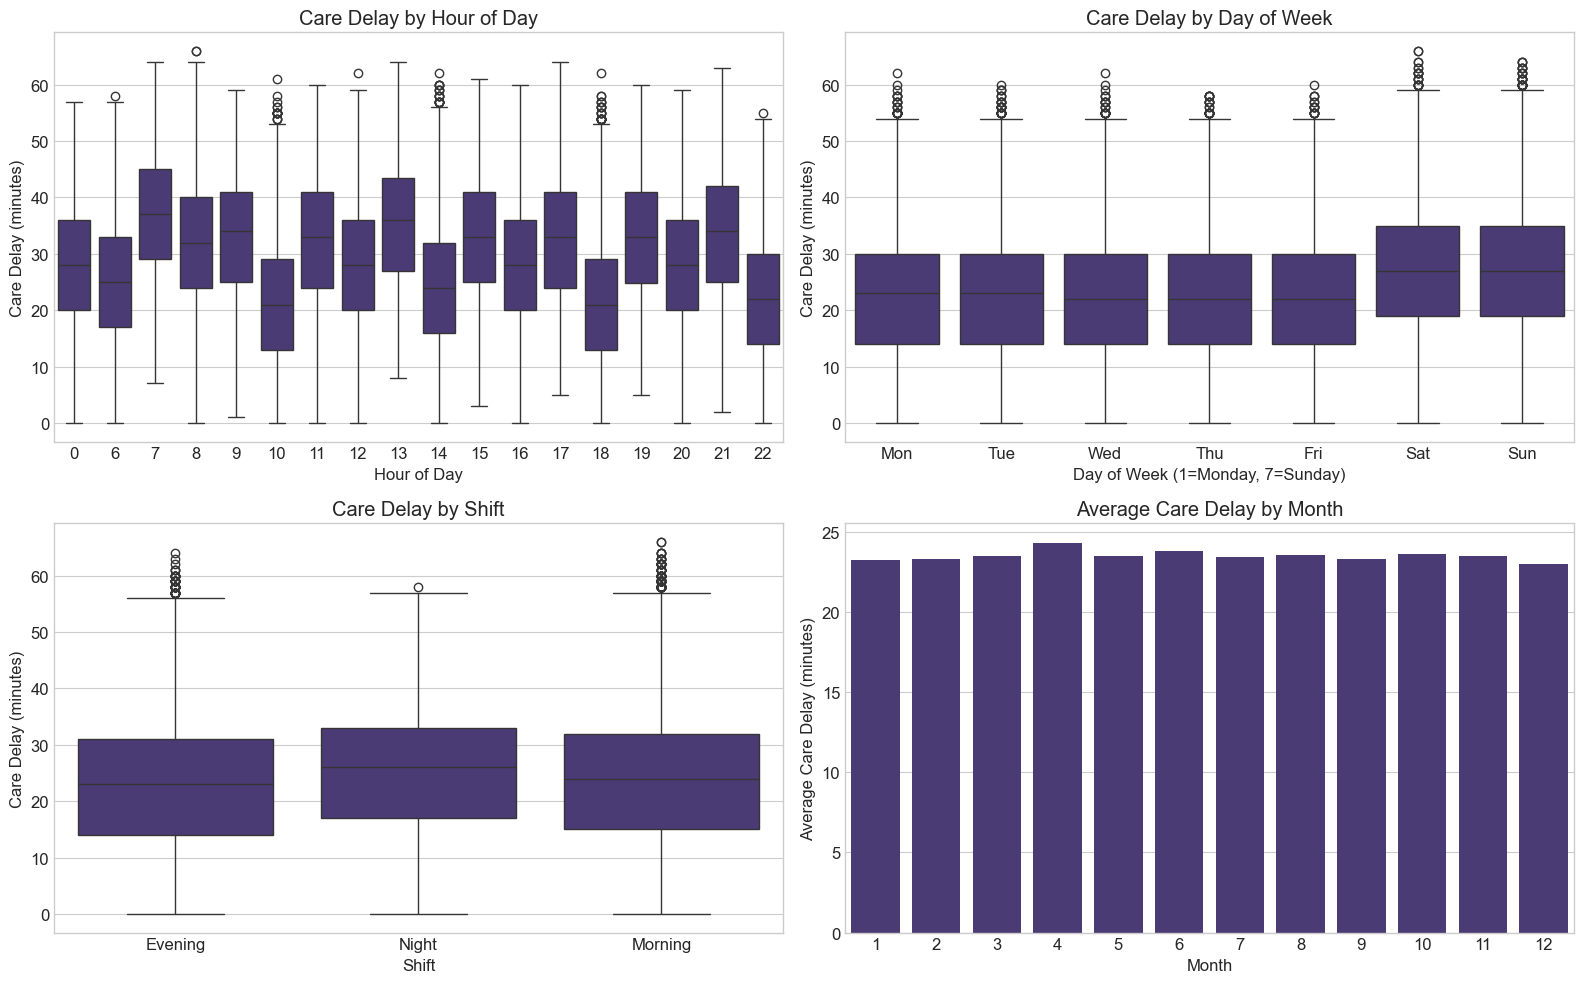

In [41]:
# Temporal patterns of care delay
plt.figure(figsize=(16, 10))

plt.subplot(221)
sns.boxplot(x='hour_of_day', y='care_delay_minutes', data=df)
plt.title('Care Delay by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Care Delay (minutes)')

plt.subplot(222)
sns.boxplot(x='day_of_week', y='care_delay_minutes', data=df)
plt.title('Care Delay by Day of Week')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Care Delay (minutes)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.subplot(223)
sns.boxplot(x='shift', y='care_delay_minutes', data=df)
plt.title('Care Delay by Shift')
plt.xlabel('Shift')
plt.ylabel('Care Delay (minutes)')

plt.subplot(224)
df_monthly = df.groupby('month')['care_delay_minutes'].mean().reset_index()
sns.barplot(x='month', y='care_delay_minutes', data=df_monthly)
plt.title('Average Care Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Care Delay (minutes)')

plt.tight_layout()
plt.show()

### Exploratory Data Analysis - Patient Factors

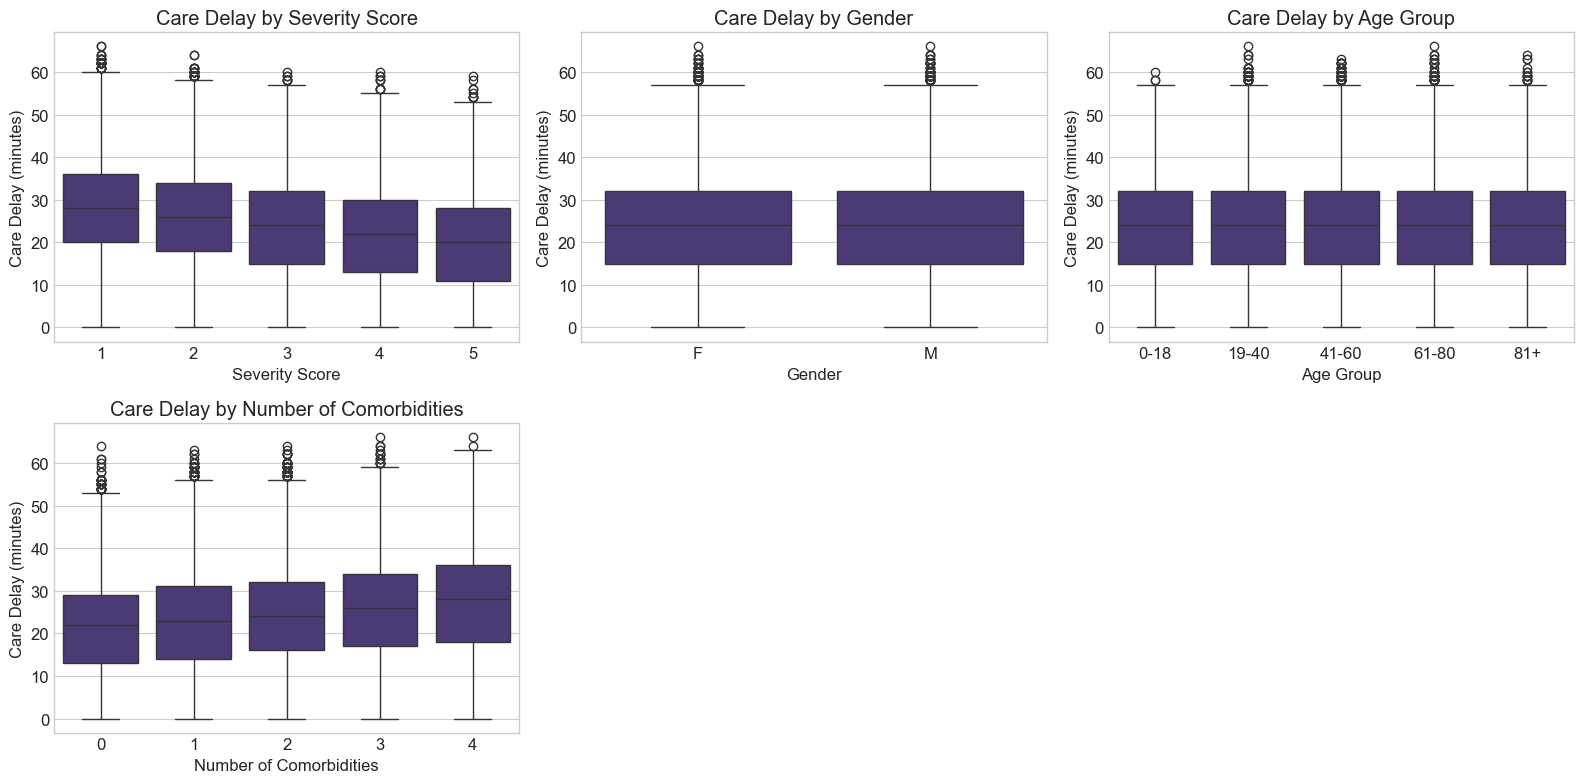

In [42]:
# Patient attributes impact on care delay
plt.figure(figsize=(16, 8))

plt.subplot(231)
sns.boxplot(x='severity_score', y='care_delay_minutes', data=df)
plt.title('Care Delay by Severity Score')
plt.xlabel('Severity Score')
plt.ylabel('Care Delay (minutes)')

plt.subplot(232)
sns.boxplot(x='gender', y='care_delay_minutes', data=df)
plt.title('Care Delay by Gender')
plt.xlabel('Gender')
plt.ylabel('Care Delay (minutes)')

plt.subplot(233)
# Age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 40, 60, 80, 100], 
                          labels=['0-18', '19-40', '41-60', '61-80', '81+'])
sns.boxplot(x='age_group', y='care_delay_minutes', data=df)
plt.title('Care Delay by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Care Delay (minutes)')

plt.subplot(234)
sns.boxplot(x='num_comorbidities', y='care_delay_minutes', data=df)
plt.title('Care Delay by Number of Comorbidities')
plt.xlabel('Number of Comorbidities')
plt.ylabel('Care Delay (minutes)')

plt.tight_layout()
plt.show()

### Exploratory Data Analysis - Ward Conditions

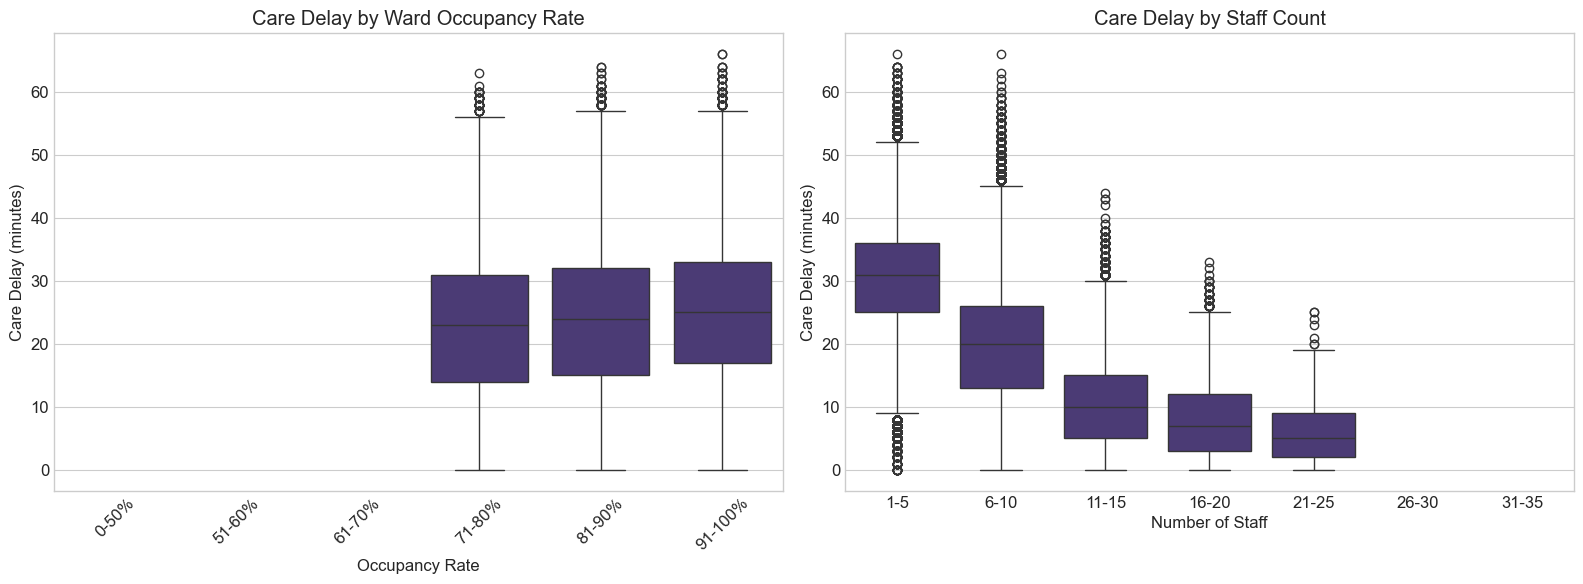

In [43]:
# Ward conditions impact
plt.figure(figsize=(16, 6))

plt.subplot(121)
# Create occupancy rate bins
df['occupancy_bin'] = pd.cut(df['occupancy_rate'], 
                            bins=[0, 50, 60, 70, 80, 90, 100],
                            labels=['0-50%', '51-60%', '61-70%', '71-80%', '81-90%', '91-100%'])
sns.boxplot(x='occupancy_bin', y='care_delay_minutes', data=df)
plt.title('Care Delay by Ward Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Care Delay (minutes)')
plt.xticks(rotation=45)

plt.subplot(122)
# Staff count binned
df['staff_bin'] = pd.cut(df['staff_count'], 
                        bins=[0, 5, 10, 15, 20, 25, 30, 35],
                        labels=['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35'])
sns.boxplot(x='staff_bin', y='care_delay_minutes', data=df)
plt.title('Care Delay by Staff Count')
plt.xlabel('Number of Staff')
plt.ylabel('Care Delay (minutes)')

plt.tight_layout()
plt.show()

### Correlation Analysis

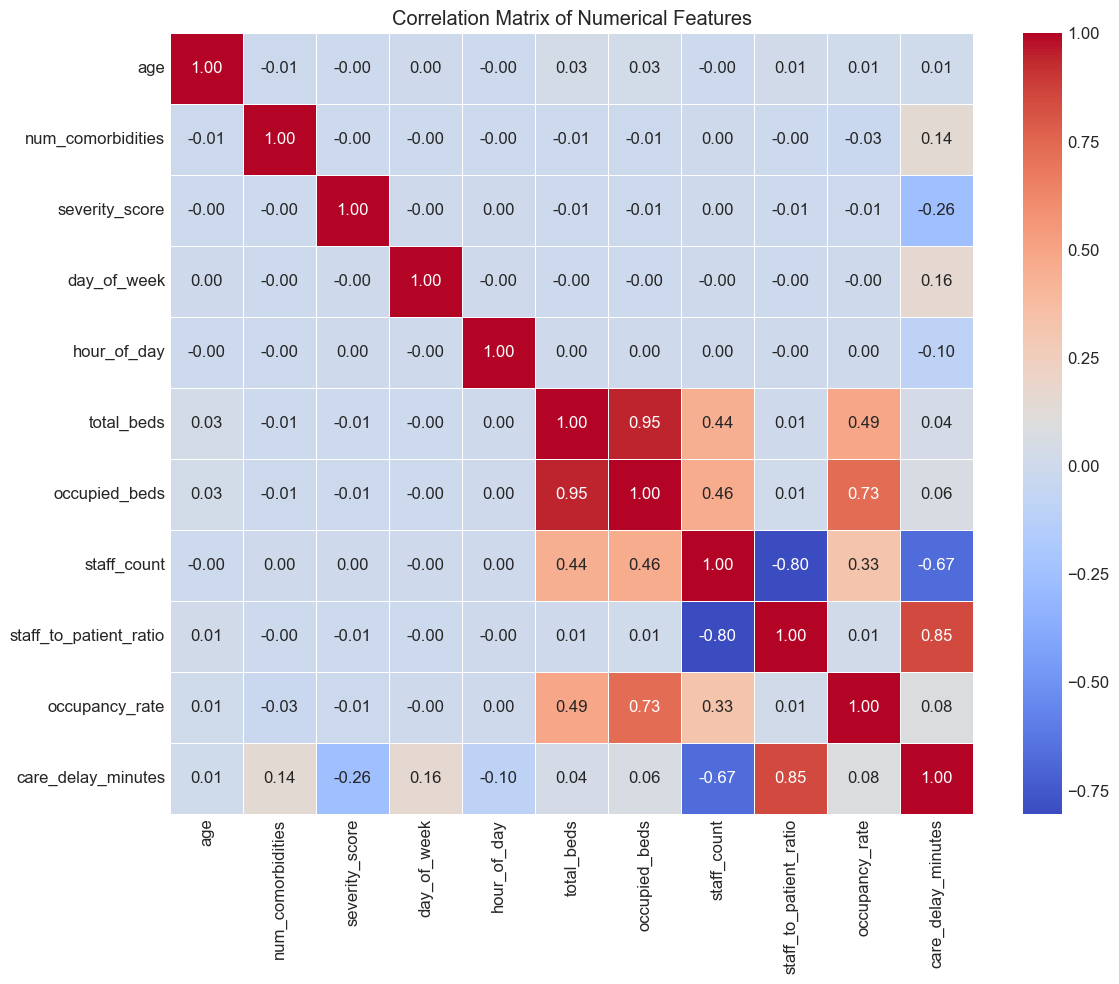

Feature correlations with Care Delay:
care_delay_minutes        1.000000
staff_to_patient_ratio    0.845802
day_of_week               0.159223
num_comorbidities         0.144328
occupancy_rate            0.084341
occupied_beds             0.060915
total_beds                0.039171
age                       0.012882
hour_of_day              -0.098370
severity_score           -0.256895
staff_count              -0.671660
Name: care_delay_minutes, dtype: float64


In [44]:
# Numerical correlation analysis
numeric_columns = ['age', 'num_comorbidities', 'severity_score', 'day_of_week', 
                  'hour_of_day', 'total_beds', 'occupied_beds', 'staff_count', 
                  'staff_to_patient_ratio', 'occupancy_rate', 'care_delay_minutes']

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Sort correlations with target variable
target_correlations = correlation_matrix['care_delay_minutes'].sort_values(ascending=False)
print("Feature correlations with Care Delay:")
print(target_correlations)

### Diagnosis Analysis

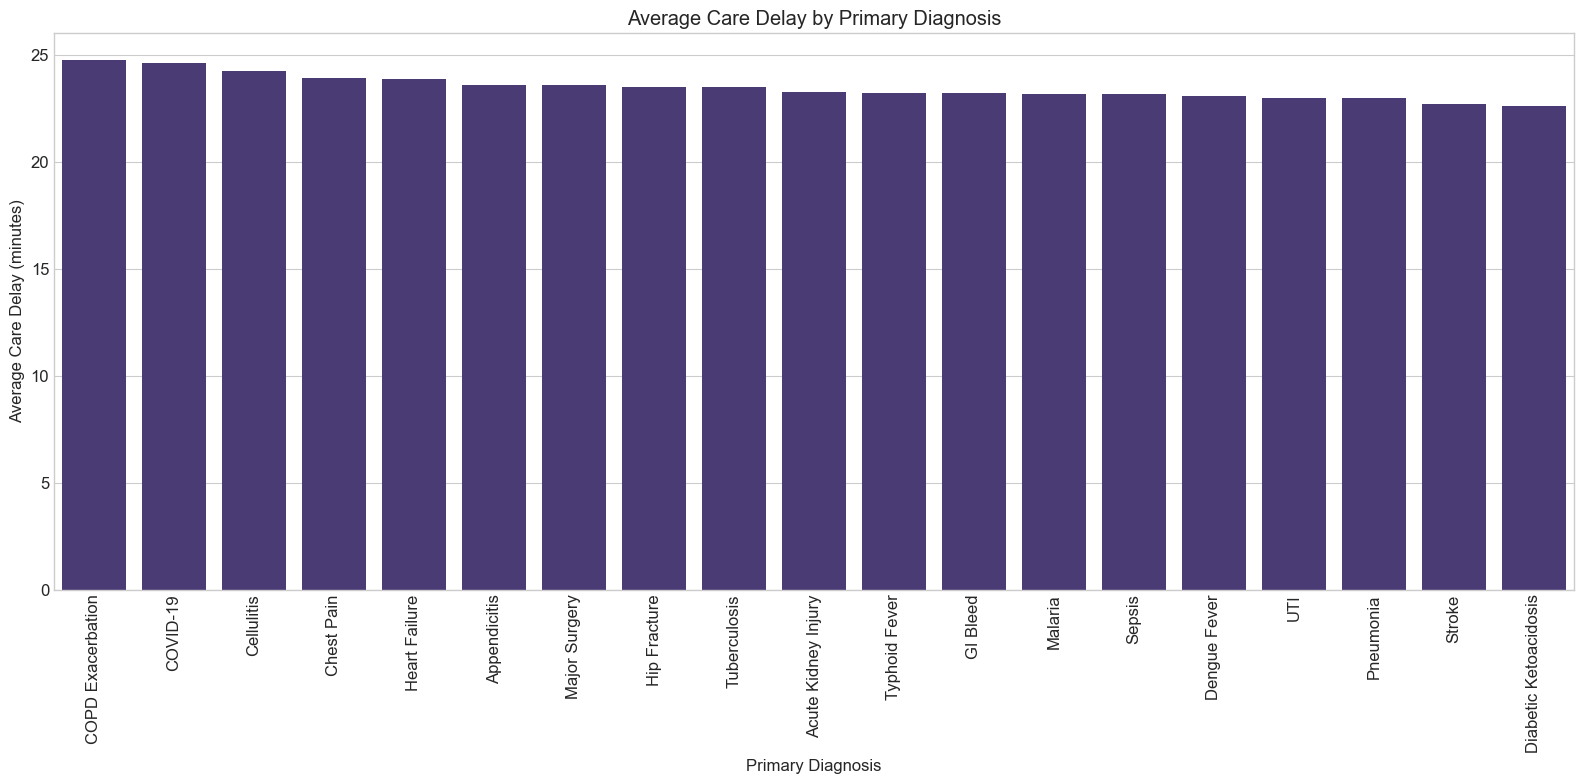

Top 5 diagnoses with highest average delay:
                        mean  count
primary_diagnosis                  
COPD Exacerbation  24.797380  24731
COVID-19           24.660013  78100
Cellulitis         24.256654  20288
Chest Pain         23.942640   9205
Heart Failure      23.909528  41582


In [45]:
# Analyze impact of primary diagnosis on care delay
plt.figure(figsize=(16, 8))
diagnosis_delay = df.groupby('primary_diagnosis')['care_delay_minutes'].agg(['mean', 'count']).sort_values('mean', ascending=False)
diagnosis_delay = diagnosis_delay[diagnosis_delay['count'] > 100]  # Filter for significant sample size

# Plot top diagnoses by delay
sns.barplot(x=diagnosis_delay.index, y=diagnosis_delay['mean'])
plt.title('Average Care Delay by Primary Diagnosis')
plt.xlabel('Primary Diagnosis')
plt.ylabel('Average Care Delay (minutes)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Top 5 diagnoses with highest average delay:")
print(diagnosis_delay.head(5))

### Feature Engineering

In [46]:
# Create features for modeling

# 1. One-hot encode categorical variables
# Let's first define our categorical columns
categorical_cols = ['gender', 'primary_diagnosis', 'shift']

# 2. Create additional features
# Create a binary weekend indicator
df['is_weekend'] = (df['day_of_week'] > 5).astype(int)

# Create peak hour indicators (morning and afternoon peaks)
df['is_peak_morning'] = ((df['hour_of_day'] >= 6) & (df['hour_of_day'] < 9)).astype(int)
df['is_peak_afternoon'] = ((df['hour_of_day'] >= 13) & (df['hour_of_day'] < 15)).astype(int)

# Create occupancy stress indicator (high occupancy)
df['high_occupancy'] = (df['occupancy_rate'] > 85).astype(int)

# Create staff-to-bed ratio (total beds per staff)
df['beds_per_staff'] = df['total_beds'] / df['staff_count']

# Calculate occupancy per staff (patient load)
df['patients_per_staff'] = df['occupied_beds'] / df['staff_count']

# Create "busy day" indicator (Monday or Friday)
df['is_busy_day'] = df['day_of_week'].isin([1, 5]).astype(int)

# Create comorbidity severity interaction
df['comorbidity_severity'] = df['num_comorbidities'] * df['severity_score']

# Encode time information using cyclical encoding for hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day']/24)

# Encode day of week using cyclical encoding
df['day_sin'] = np.sin(2 * np.pi * (df['day_of_week']-1)/7)
df['day_cos'] = np.cos(2 * np.pi * (df['day_of_week']-1)/7)

# Display the new features
print("Dataset with new features:")
df[['is_weekend', 'is_peak_morning', 'is_peak_afternoon', 'high_occupancy', 
    'beds_per_staff', 'patients_per_staff', 'is_busy_day', 'comorbidity_severity',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos']].head()

Dataset with new features:


,is_weekend,is_peak_morning,is_peak_afternoon,high_occupancy,beds_per_staff,patients_per_staff,is_busy_day,comorbidity_severity,hour_sin,hour_cos,day_sin,day_cos
0,0,0,0,0,3.7,2.7,1,4,-0.500000,8.660254e-01,-0.433884,-0.900969
1,1,1,0,0,3.7,2.7,0,4,1.000000,6.123234e-17,-0.974928,-0.222521
2,1,1,0,0,3.7,2.7,0,4,0.866025,-5.000000e-01,-0.974928,-0.222521
3,1,0,0,0,3.7,2.7,0,4,0.500000,-8.660254e-01,-0.974928,-0.222521
4,1,0,1,0,3.7,2.7,0,4,-0.500000,-8.660254e-01,-0.974928,-0.222521


### Prepare Data for Modeling

In [47]:
# Define features to use in modeling
target = 'care_delay_minutes'

# Define features excluding non-predictive columns
exclude_columns = ['mrn', 'comorbidities', 'care_date', 'scheduled_care_time', 
                  'actual_care_time', 'care_end_time', 'scheduled_time', 
                  'actual_time', 'end_time', 'scheduled_hour', 'actual_hour',
                  'month', 'day', 'year', 'age_group', 'occupancy_bin', 'staff_bin', 'care_duration_minutes']

# Create feature list (all columns except target and excluded columns)
features = [col for col in df.columns if col not in [target] + exclude_columns]

print(f"Target variable: {target}")
print(f"Number of features: {len(features)}")
print("Features:")
print(features)

# Split categorical and numerical features
categorical_features = [col for col in features if df[col].dtype == 'object' or col in categorical_cols]
numerical_features = [col for col in features if col not in categorical_features]

print(f"\nNumerical features ({len(numerical_features)}):")
print(numerical_features)
print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)

# Split data into training and testing sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Target variable: care_delay_minutes
Number of features: 25
Features:
['age', 'gender', 'num_comorbidities', 'severity_score', 'primary_diagnosis', 'total_beds', 'occupied_beds', 'staff_count', 'staff_to_patient_ratio', 'day_of_week', 'hour_of_day', 'shift', 'occupancy_rate', 'is_weekend', 'is_peak_morning', 'is_peak_afternoon', 'high_occupancy', 'beds_per_staff', 'patients_per_staff', 'is_busy_day', 'comorbidity_severity', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

Numerical features (22):
['age', 'num_comorbidities', 'severity_score', 'total_beds', 'occupied_beds', 'staff_count', 'staff_to_patient_ratio', 'day_of_week', 'hour_of_day', 'occupancy_rate', 'is_weekend', 'is_peak_morning', 'is_peak_afternoon', 'high_occupancy', 'beds_per_staff', 'patients_per_staff', 'is_busy_day', 'comorbidity_severity', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

Categorical features (3):
['gender', 'primary_diagnosis', 'shift']

Training set shape: (629580, 25)
Testing set shape: (157395, 25)


### Create Preprocessing Pipeline

In [48]:
# Define preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models to test
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1)
}

### Initial Model Evaluation

In [49]:
# Function to evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test, preprocessor):
    results = {}
    
    print("Evaluating models...")
    for name, model in models.items():
        # Create pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Train the model
        print(f"\nTraining {name}...")
        pipeline.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Store results
        results[name] = {
            'model': pipeline,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'mae': mae
        }
        
        print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}")
    
    return results

# Evaluate all models
model_results = evaluate_models(models, X_train, X_test, y_train, y_test, preprocessor)


Evaluating models...

Training LinearRegression...
LinearRegression - RMSE: 3.90, R²: 0.8791, MAE: 3.01

Training Ridge...
Ridge - RMSE: 3.90, R²: 0.8791, MAE: 3.01

Training Lasso...
Lasso - RMSE: 4.86, R²: 0.8124, MAE: 3.86

Training ElasticNet...
ElasticNet - RMSE: 5.12, R²: 0.7923, MAE: 4.07

Training DecisionTree...
DecisionTree - RMSE: 4.34, R²: 0.8505, MAE: 3.39

Training RandomForest...
RandomForest - RMSE: 3.59, R²: 0.8978, MAE: 2.81

Training GradientBoosting...
GradientBoosting - RMSE: 3.25, R²: 0.9162, MAE: 2.54

Training AdaBoost...
AdaBoost - RMSE: 4.89, R²: 0.8106, MAE: 3.98

Training XGBoost...
XGBoost - RMSE: 3.17, R²: 0.9202, MAE: 2.48

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set:

### Compare Model Performance

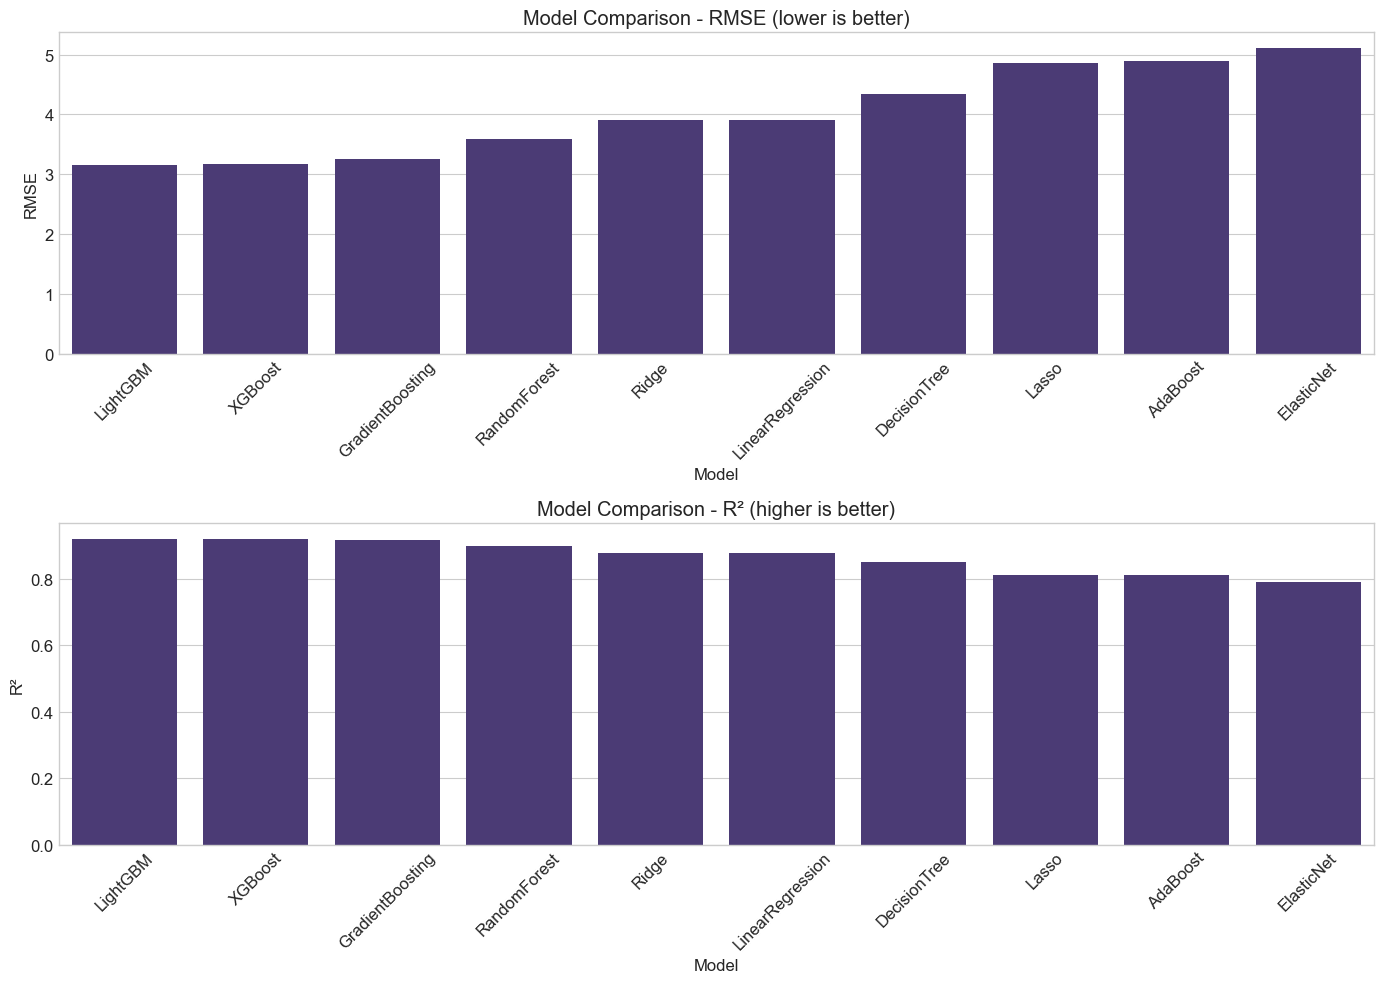

Model comparison results:
              Model      RMSE        R²       MAE
9          LightGBM  3.150683  0.921245  2.463730
8           XGBoost  3.170779  0.920237  2.478333
6  GradientBoosting  3.249223  0.916242  2.544149
5      RandomForest  3.589635  0.897772  2.808643
1             Ridge  3.903553  0.879111  3.013239
0  LinearRegression  3.903554  0.879111  3.013232
4      DecisionTree  4.341234  0.850482  3.393234
2             Lasso  4.862892  0.812389  3.856336
7          AdaBoost  4.886133  0.810592  3.975363
3        ElasticNet  5.117064  0.792265  4.069098

Top 3 performing models: LightGBM, XGBoost, GradientBoosting


In [50]:
# Compare model performance
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'RMSE': [model_results[m]['rmse'] for m in model_results],
    'R²': [model_results[m]['r2'] for m in model_results],
    'MAE': [model_results[m]['mae'] for m in model_results]
})

# Sort by RMSE (lower is better)
results_df = results_df.sort_values('RMSE')

# Plot results
plt.figure(figsize=(14, 10))

plt.subplot(211)
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('Model Comparison - RMSE (lower is better)')
plt.xticks(rotation=45)

plt.subplot(212)
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('Model Comparison - R² (higher is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Model comparison results:")
print(results_df)

# Identify top 3 models
top_models = results_df.head(3)['Model'].values
print(f"\nTop 3 performing models: {', '.join(top_models)}")

### Feature Importance Analysis

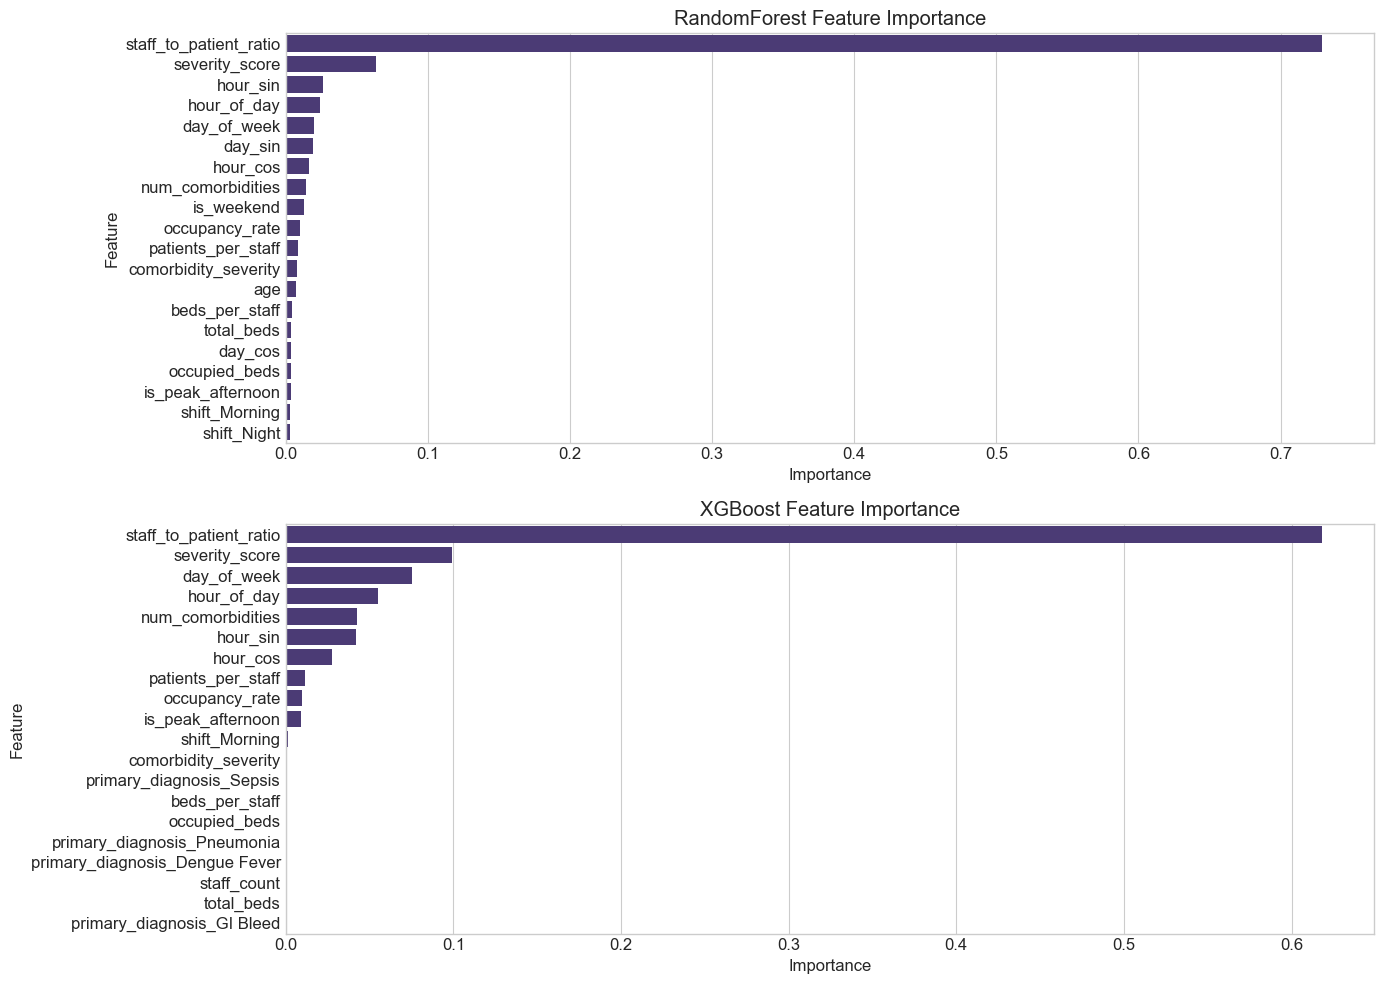

In [51]:
def get_feature_importance(model_name, pipeline):
    """
    Extract feature importance from a sklearn pipeline containing a model with feature_importances_ attribute.
    Works with Pipeline > ColumnTransformer > (numeric and categorical transformers)
    """
    # Extract the model from the pipeline
    model = pipeline.named_steps['model']
    
    # Get feature names after preprocessing
    preprocessor = pipeline.named_steps['preprocessor']
    
    # Get column names from each transformer in the ColumnTransformer
    feature_names = []
    
    # Loop through all transformers in the ColumnTransformer
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            # Numerical features keep their original names
            feature_names.extend(columns)
        elif name == 'cat':
            # For categorical features, we need to get the one-hot encoded feature names
            # The transformer here is another pipeline, with an OHE step
            if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
                ohe = transformer.named_steps['onehot']
                if hasattr(ohe, 'get_feature_names_out'):
                    cat_feature_names = ohe.get_feature_names_out(columns)
                    feature_names.extend(cat_feature_names)
                else:
                    # Fallback for older scikit-learn versions
                    print(f"Warning: OneHotEncoder doesn't have get_feature_names_out method")
                    # Just add the column names with a warning
                    feature_names.extend([f"{col}_encoded" for col in columns])
    
    # Get feature importances if the model supports it
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Validate that lengths match
        if len(importances) != len(feature_names):
            print(f"Warning: Feature importance length ({len(importances)}) doesn't match feature names length ({len(feature_names)})")
            # Create a simple index-based feature name
            feature_names = [f"feature_{i}" for i in range(len(importances))]
        
        # Create a dataframe of feature importances
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        return feature_importance
    else:
        print(f"{model_name} does not support feature importances")
        return None

# Using the function:
rf_importance = None
xgb_importance = None

if 'RandomForest' in model_results:
    rf_importance = get_feature_importance('RandomForest', model_results['RandomForest']['model'])
    
if 'XGBoost' in model_results:
    xgb_importance = get_feature_importance('XGBoost', model_results['XGBoost']['model'])

# Plot feature importance for top 20 features
plt.figure(figsize=(14, 10))

if rf_importance is not None:
    plt.subplot(211)
    sns.barplot(x='Importance', y='Feature', data=rf_importance.head(20))
    plt.title('RandomForest Feature Importance')
    plt.tight_layout()

if xgb_importance is not None:
    plt.subplot(212)
    sns.barplot(x='Importance', y='Feature', data=xgb_importance.head(20))
    plt.title('XGBoost Feature Importance')
    
plt.tight_layout()
plt.show()

### Hyperparameter Tuning for Top Models

In [52]:
# Perform hyperparameter tuning for the top models
def hyperparameter_tune(model_name, X_train, y_train, preprocessor):
    print(f"Tuning hyperparameters for {model_name}...")
    
    # Define param grids for different models
    param_grids = {
        'RandomForest': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'GradientBoosting': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        },
        'XGBoost': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__colsample_bytree': [0.7, 0.8, 0.9],
            'model__subsample': [0.7, 0.8, 0.9]
        },
        'LightGBM': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__num_leaves': [31, 50, 70],
            'model__subsample': [0.7, 0.8, 0.9]
        }
    }
    
    # Create base model
    if model_name == 'RandomForest':
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif model_name == 'GradientBoosting':
        model = GradientBoostingRegressor(random_state=42)
    elif model_name == 'XGBoost':
        model = XGBRegressor(random_state=42, n_jobs=-1)
    elif model_name == 'LightGBM':
        model = LGBMRegressor(random_state=42, n_jobs=-1)
    else:
        print(f"No hyperparameter grid defined for {model_name}")
        return None
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Create grid search
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grids[model_name],
        n_iter=10,
        scoring='neg_root_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Return best model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best RMSE: {-grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Tune top models
tuned_models = {}

# You might want to run this only for your top 2-3 models to save time
for model_name in top_models[:2]:  # Take top 2 models
    if model_name in ['RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']:
        tuned_models[model_name] = hyperparameter_tune(model_name, X_train, y_train, preprocessor)

Tuning hyperparameters for LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.517714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.515203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.498995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.515203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.515203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.515203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.517714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 419720, number of used features: 46
[LightGBM] [Info] Start training from score 23.498995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/kshitizbhatnagar/Desktop/Hospital Simulation/Avg Care Delay/Model/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 629580, number of used features: 46
[LightGBM] [Info] Start training from score 23.510637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

### Evaluate Tuned Models

Tuned LightGBM - RMSE: 3.15, R²: 0.9215, MAE: 2.46
Tuned XGBoost - RMSE: 3.15, R²: 0.9215, MAE: 2.46


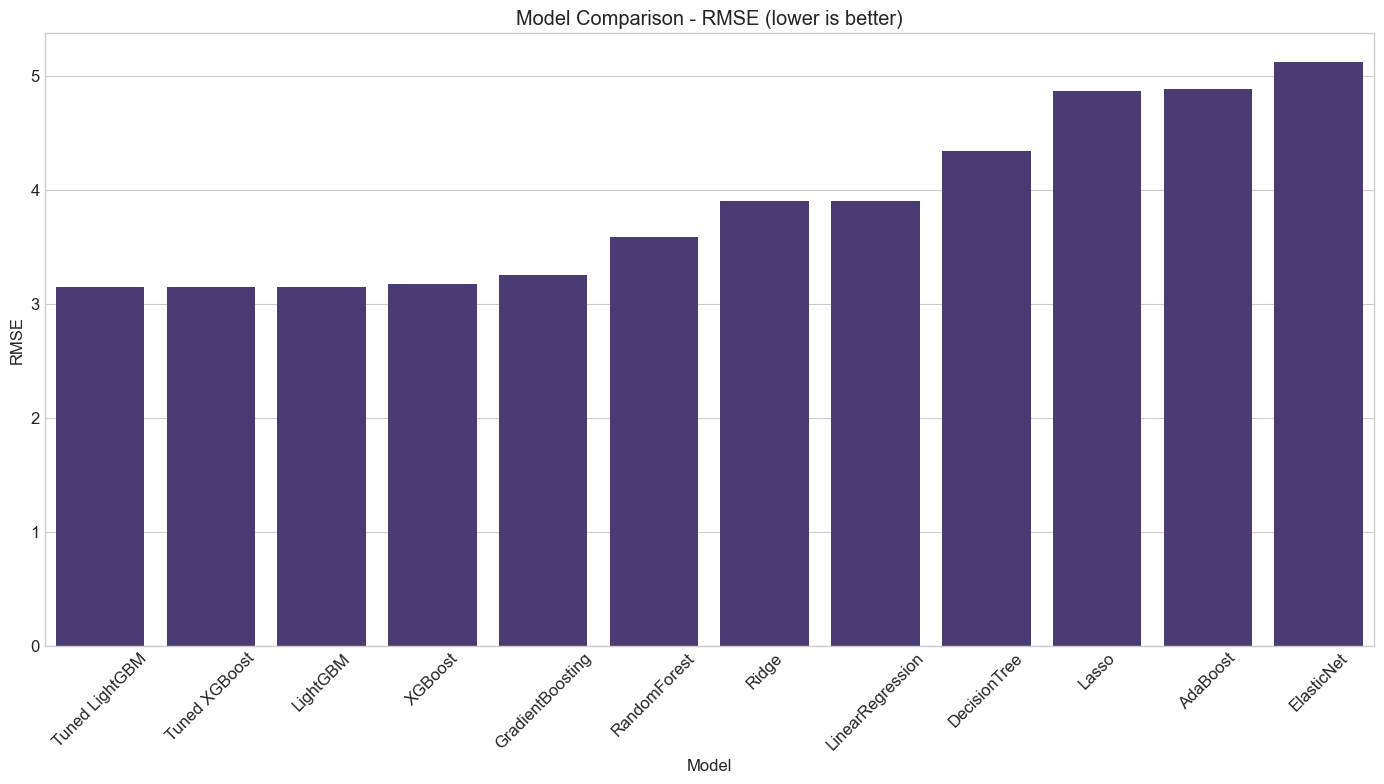

Final model comparison:
               Model      RMSE        R²       MAE
10    Tuned LightGBM  3.145138  0.921522  2.457836
11     Tuned XGBoost  3.145750  0.921492  2.459177
9           LightGBM  3.150683  0.921245  2.463730
8            XGBoost  3.170779  0.920237  2.478333
6   GradientBoosting  3.249223  0.916242  2.544149
5       RandomForest  3.589635  0.897772  2.808643
1              Ridge  3.903553  0.879111  3.013239
0   LinearRegression  3.903554  0.879111  3.013232
4       DecisionTree  4.341234  0.850482  3.393234
2              Lasso  4.862892  0.812389  3.856336


In [53]:
# Evaluate tuned models
tuned_results = {}

for model_name, model in tuned_models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    tuned_results[model_name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mae': mae
    }
    
    print(f"Tuned {model_name} - RMSE: {rmse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}")

# Compare with base models
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()) + [f"Tuned {m}" for m in tuned_results.keys()],
    'RMSE': [model_results[m]['rmse'] for m in model_results] + 
            [tuned_results[m]['rmse'] for m in tuned_results],
    'R²': [model_results[m]['r2'] for m in model_results] + 
         [tuned_results[m]['r2'] for m in tuned_results],
    'MAE': [model_results[m]['mae'] for m in model_results] + 
          [tuned_results[m]['mae'] for m in tuned_results]
})

# Sort by RMSE
comparison_df = comparison_df.sort_values('RMSE')

# Plot results
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='RMSE', data=comparison_df)
plt.title('Model Comparison - RMSE (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Final model comparison:")
print(comparison_df.head(10))


### Analyze Prediction Errors

Best model: Tuned LightGBM


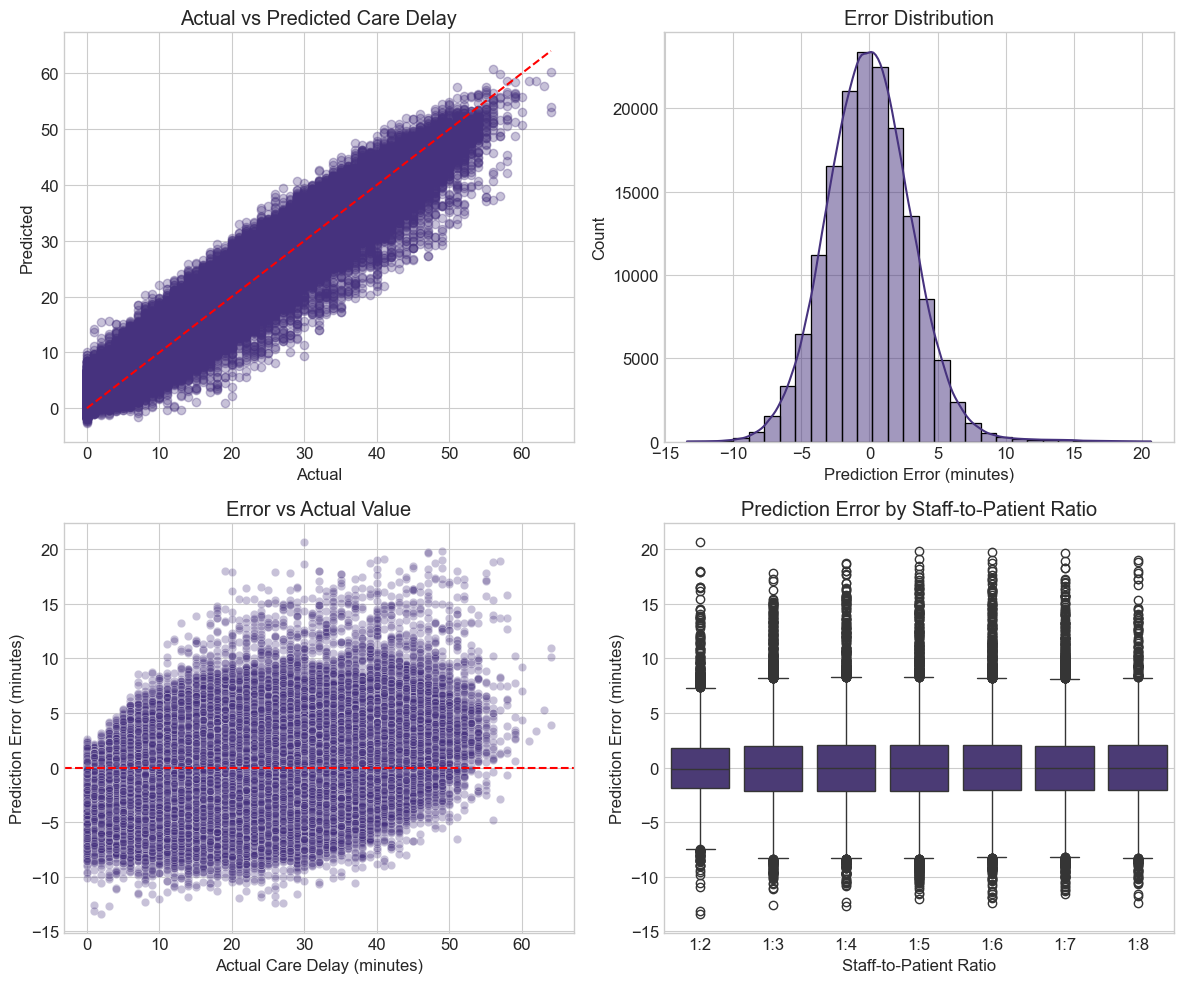

In [54]:
# Select the best model
best_model_name = comparison_df.iloc[0]['Model']
if best_model_name.startswith('Tuned '):
    model_key = best_model_name.replace('Tuned ', '')
    best_model = tuned_results[model_key]['model']
else:
    best_model = model_results[best_model_name]['model']

print(f"Best model: {best_model_name}")

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Create a dataframe with actual and predicted values
pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred
})

# Plot actual vs predicted
plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Care Delay')

plt.subplot(222)
sns.histplot(pred_df['Error'], kde=True, bins=30)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (minutes)')

plt.subplot(223)
sns.scatterplot(x='Actual', y='Error', data=pred_df, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Error vs Actual Value')
plt.xlabel('Actual Care Delay (minutes)')
plt.ylabel('Prediction Error (minutes)')

plt.subplot(224)
# Get test data with original features
X_test_with_features = X_test.copy()
ratio_bins = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]
ratio_labels = ['1:2', '1:3', '1:4', '1:5', '1:6', '1:7', '1:8']
X_test_with_features['ratio_group'] = pd.cut(X_test_with_features['staff_to_patient_ratio'], 
                                            bins=ratio_bins, 
                                            labels=ratio_labels)

# Add predictions and errors
X_test_with_features['Actual'] = y_test
X_test_with_features['Predicted'] = y_pred
X_test_with_features['Error'] = X_test_with_features['Actual'] - X_test_with_features['Predicted']

# Plot error by ratio group
sns.boxplot(x='ratio_group', y='Error', data=X_test_with_features)
plt.title('Prediction Error by Staff-to-Patient Ratio')
plt.xlabel('Staff-to-Patient Ratio')
plt.ylabel('Prediction Error (minutes)')

plt.tight_layout()
plt.show()

### Error Analysis by Patient Groups

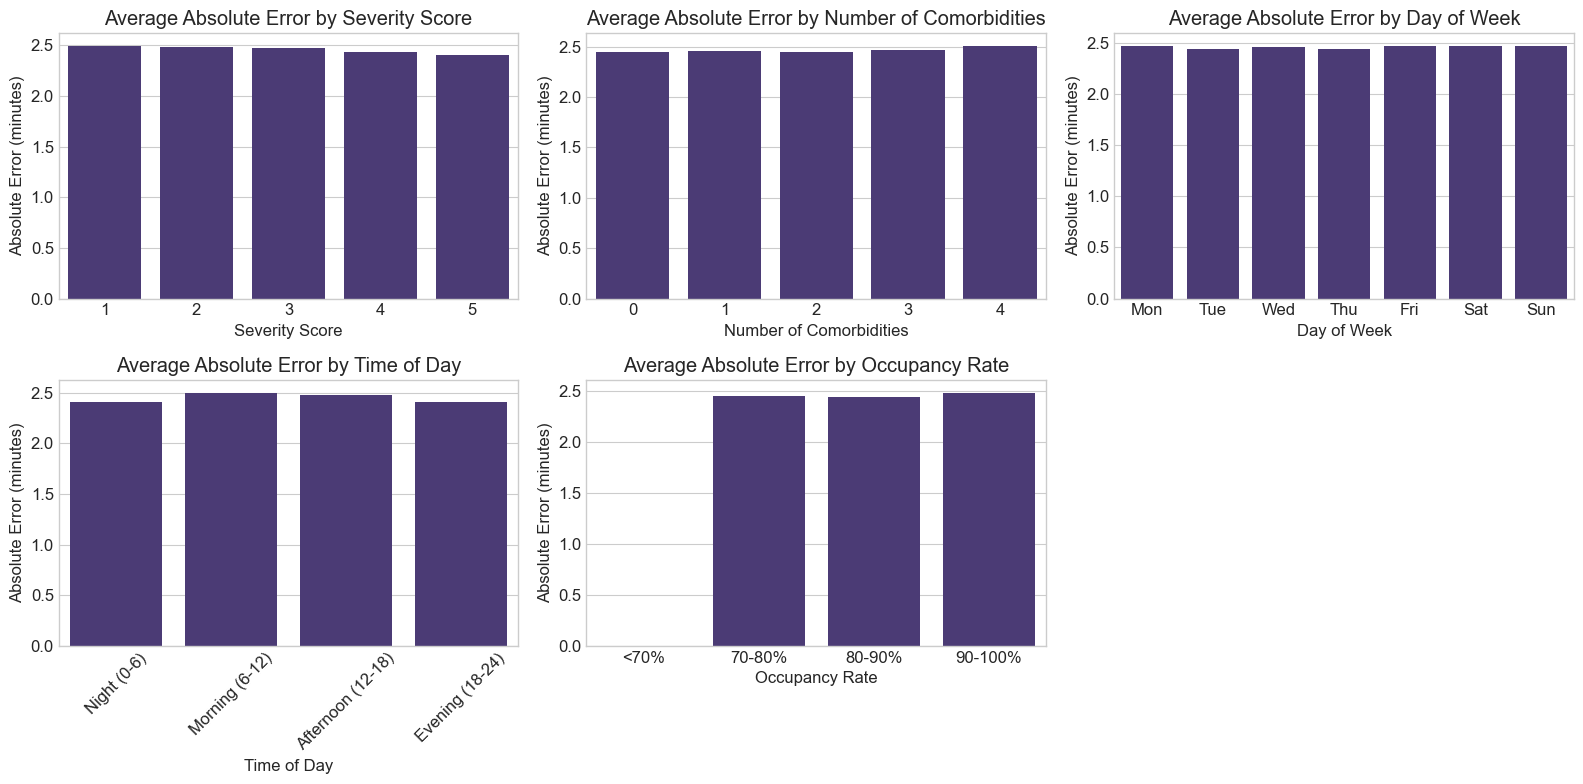

In [55]:
# Analyze error by different patient groups
plt.figure(figsize=(16, 8))

# Add some test features back
X_test_with_more = X_test.copy()
X_test_with_more['Actual'] = y_test
X_test_with_more['Predicted'] = y_pred
X_test_with_more['Error'] = X_test_with_more['Actual'] - X_test_with_more['Predicted']
X_test_with_more['AbsError'] = abs(X_test_with_more['Error'])

# Group by severity
plt.subplot(231)
severity_error = X_test_with_more.groupby('severity_score')['AbsError'].mean()
sns.barplot(x=severity_error.index, y=severity_error.values)
plt.title('Average Absolute Error by Severity Score')
plt.xlabel('Severity Score')
plt.ylabel('Absolute Error (minutes)')

# Group by comorbidities
plt.subplot(232)
comorbid_error = X_test_with_more.groupby('num_comorbidities')['AbsError'].mean()
sns.barplot(x=comorbid_error.index, y=comorbid_error.values)
plt.title('Average Absolute Error by Number of Comorbidities')
plt.xlabel('Number of Comorbidities')
plt.ylabel('Absolute Error (minutes)')

# Group by day of week
plt.subplot(233)
day_error = X_test_with_more.groupby('day_of_week')['AbsError'].mean()
sns.barplot(x=day_error.index, y=day_error.values)
plt.title('Average Absolute Error by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Absolute Error (minutes)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Group by hour of day (binned)
plt.subplot(234)
X_test_with_more['hour_bin'] = pd.cut(X_test_with_more['hour_of_day'], 
                                     bins=[0, 6, 12, 18, 24], 
                                     labels=['Night (0-6)', 'Morning (6-12)', 
                                             'Afternoon (12-18)', 'Evening (18-24)'])
hour_error = X_test_with_more.groupby('hour_bin')['AbsError'].mean()
sns.barplot(x=hour_error.index, y=hour_error.values)
plt.title('Average Absolute Error by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Absolute Error (minutes)')
plt.xticks(rotation=45)

# Group by occupancy (binned)
plt.subplot(235)
X_test_with_more['occupancy_bin'] = pd.cut(X_test_with_more['occupancy_rate'], 
                                         bins=[0, 70, 80, 90, 100], 
                                         labels=['<70%', '70-80%', '80-90%', '90-100%'])
occupancy_error = X_test_with_more.groupby('occupancy_bin')['AbsError'].mean()
sns.barplot(x=occupancy_error.index, y=occupancy_error.values)
plt.title('Average Absolute Error by Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Absolute Error (minutes)')

plt.tight_layout()
plt.show()

### Save the Final Model

In [56]:
# Save the best model to disk
final_model = best_model  # This is the best model pipeline (includes preprocessing)

# Define the model file name
model_filename = "care_delay_prediction_model.pkl"

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(final_model, file)

print(f"Model saved as {model_filename}")

# Save a list of required features
with open('model_features.pkl', 'wb') as file:
    pickle.dump(features, file)

print("Required features list saved")

# Also save the feature preprocessing information
with open('feature_preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

print("Feature preprocessor saved")

# Create a simple model info summary
model_info = {
    'model_name': best_model_name,
    'performance': {
        'rmse': comparison_df.iloc[0]['RMSE'],
        'r2': comparison_df.iloc[0]['R²'],
        'mae': comparison_df.iloc[0]['MAE']
    },
    'features': features,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'target': target
}

with open('model_info.pkl', 'wb') as file:
    pickle.dump(model_info, file)

print("Model info saved")

Model saved as care_delay_prediction_model.pkl
Required features list saved
Feature preprocessor saved
Model info saved


### Feature Importance of Final Model

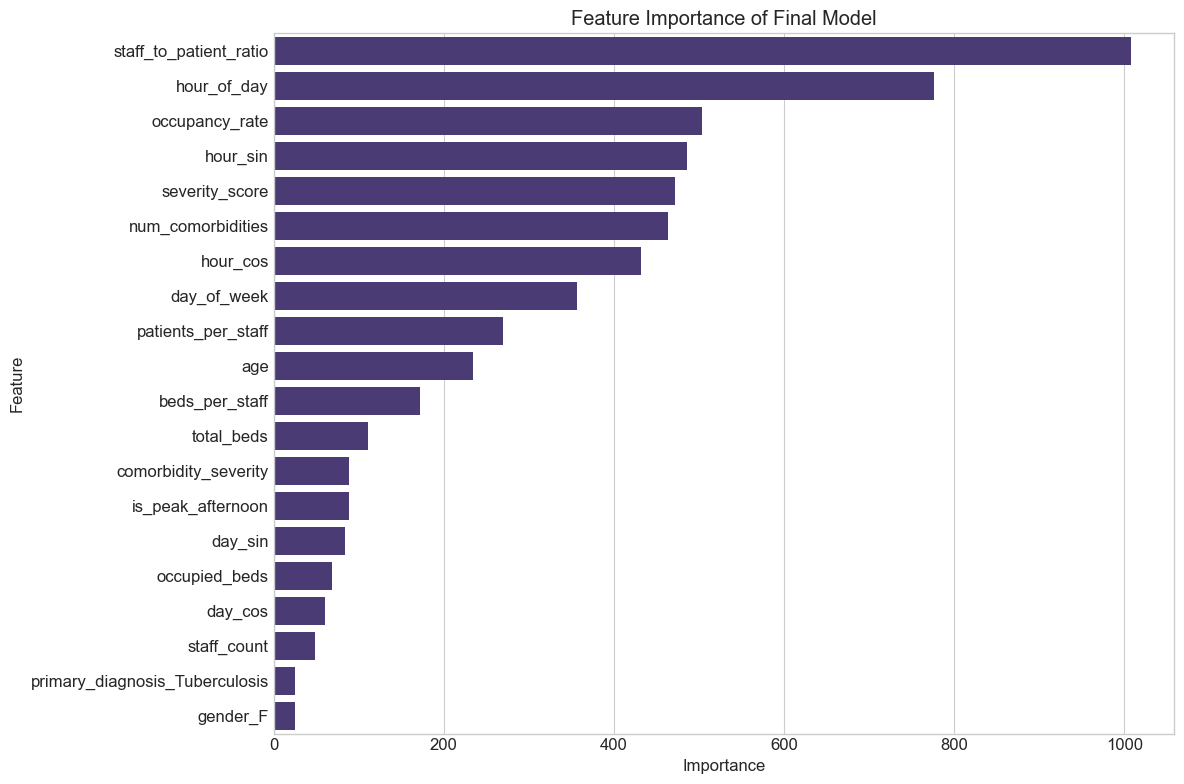

Top 20 most important features:
                           Feature  Importance
6           staff_to_patient_ratio        1008
8                      hour_of_day         776
9                   occupancy_rate         504
18                        hour_sin         486
2                   severity_score         472
1                num_comorbidities         464
19                        hour_cos         432
7                      day_of_week         357
15              patients_per_staff         270
0                              age         234
14                  beds_per_staff         172
3                       total_beds         111
17            comorbidity_severity          89
12               is_peak_afternoon          89
20                         day_sin          84
4                    occupied_beds          69
21                         day_cos          60
5                      staff_count          49
40  primary_diagnosis_Tuberculosis          25
22                        ge

In [57]:
# Get feature importance of the final model
def get_final_feature_importance(model, features, X_train, preprocessor):
    # Check if the model is a pipeline
    if hasattr(model, 'named_steps'):
        # If model is a Pipeline, extract the actual model
        actual_model = model.named_steps['model']
    else:
        actual_model = model
    
    # For tree-based models, we can get feature importance
    if hasattr(actual_model, 'feature_importances_'):
        # We need to get the feature names after preprocessing
        # First, get a sample of preprocessed data
        preprocessed_data = preprocessor.transform(X_train)
        
        # Get feature names
        feature_names = []
        
        # Handle categorical features
        for name, transformer, cols in preprocessor.transformers_:
            if name == 'cat':
                # Get onehotencoder
                ohe = transformer.named_steps['onehot']
                # Get feature names from onehotencoder
                if hasattr(ohe, 'get_feature_names_out'):
                    feature_names.extend(ohe.get_feature_names_out(cols))
            elif name == 'num':
                # Add numerical feature names directly
                feature_names.extend(cols)
        
        # Create a DataFrame of feature importances
        importances = actual_model.feature_importances_
        
        if len(importances) == len(feature_names):
            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            })
            
            # Sort by importance
            feature_importance = feature_importance.sort_values('Importance', ascending=False)
            
            return feature_importance
        else:
            print("Mismatch between feature names and importance array lengths.")
            return None
    else:
        print("Model doesn't have feature_importances_ attribute.")
        return None

# Get feature importance
final_importance = get_final_feature_importance(final_model, features, X_train, preprocessor)

if final_importance is not None:
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=final_importance.head(20))
    plt.title('Feature Importance of Final Model')
    plt.tight_layout()
    plt.show()
    
    print("Top 20 most important features:")
    print(final_importance.head(20))
    
    # Save feature importance
    final_importance.to_csv('feature_importance.csv', index=False)
    print("Feature importance saved to csv")

### Model Prediction Example

In [63]:
# Create a function to make predictions for new patients
def predict_care_delay(model, patient_data):
    """Make care delay prediction for a new patient."""
    # Convert to DataFrame
    patient_df = pd.DataFrame([patient_data])
    
    # Handle the mistakenly included feature
    if 'care_duration_minutes' not in patient_df.columns:
        patient_df['care_duration_minutes'] = 0  # Dummy value
    
    # Make prediction
    predicted_delay = model.predict(patient_df)[0]
    
    return predicted_delay

# Example patient
example_patient = {
    'age': 65,
    'gender': 'M',
    'num_comorbidities': 2,
    'severity_score': 4,
    'primary_diagnosis': 'Pneumonia',
    'day_of_week': 3,  # Wednesday
    'hour_of_day': 10,
    'shift': 'Morning',
    'total_beds': 30,
    'occupied_beds': 25,
    'staff_count': 5,
    'staff_to_patient_ratio': 5.0,
    'occupancy_rate': 83.3,
    'is_weekend': 0,
    'is_peak_morning': 1,
    'is_peak_afternoon': 0,
    'high_occupancy': 0,
    'beds_per_staff': 6.0,
    'patients_per_staff': 5.0,
    'is_busy_day': 0,
    'comorbidity_severity': 6,
    'hour_sin': np.sin(2 * np.pi * 10/24),
    'hour_cos': np.cos(2 * np.pi * 10/24),
    'day_sin': np.sin(2 * np.pi * (3-1)/7),
    'day_cos': np.cos(2 * np.pi * (3-1)/7)
}

# Make prediction
predicted_delay = predict_care_delay(final_model, example_patient)
print(f"Predicted care delay for example patient: {predicted_delay:.2f} minutes")

# Show confidence intervals (if applicable)
if hasattr(final_model, 'predict_interval'):
    lower, upper = final_model.predict_interval(pd.DataFrame([example_patient]))
    print(f"95% Prediction interval: {lower[0]:.2f} to {upper[0]:.2f} minutes")

Predicted care delay for example patient: 18.24 minutes
